# Loan Status Prediction: Lending Club, 2007-2017

***By Joe Corliss***

[Data source on Kaggle](https://www.kaggle.com/wordsforthewise/lending-club)

[Notebook on Kaggle](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73)

[Lending Club Statistics](https://www.lendingclub.com/info/download-data.action)

[GitHub Repository](https://github.com/jgcorliss/lending-club)

## Table of Contents

1. [Summary](#1)
    1. [Spoilers](#1.1)
2. [Import the Data](#2)
3. [Target Variable](#3)
4. [Feature Selection](#4)
    1. [Drop columns that have only one distinct value](#4.1)
    2. [Remove columns that have < 2% data](#4.2)
    3. [Remove irrelevant features](#4.3)
    4. [Remove features that could make predictions too easy](#4.4)
    5. [Inspect non-numerical features](#4.5)
5. [Exploratory Data Analysis](#5)
6. [Correlations with 'charged_off'](#6)
    1. [Create dummy variables](#6.1)
    2. [Compute correlations with 'charged_off'](#6.2)
7. [More Pre-processing](#7)
    1. [Train/test split](#7.1)
    2. [Imputation with mean substitution](#7.2)
    3. [Standardize the data](#7.3)
8. [Predictive Modeling: SGDClassifier](#8)
    1. [Train with grid search](#8.1)
    2. [Test set evaluation](#8.2)

# Summary
<a id="1"></a>

The goal of this project is to predict whether a loan will be fully paid or charged off. We'll remove some features that would make this prediction too easy, such as the total payments received on the loan to date.

This is my first kernel on Kaggle. I would appreciate any constructive feedback!

## Spoilers
<a id="1.1"></a>

By far the most useful features for predicting whether a loan will be paid off are 'last_fico_range_low' and 'last_fico_range_high', which hold the most recent credit score of the borrower.

We will delete features that could make the prediction too easy, or trivial.

# Import the Data
<a id="2"></a>

Import basic libraries.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Change pandas print options so we can print all desired rows/columns without truncation.

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Read in the data.

In [3]:
df = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip', low_memory=True)
# low_memory=False prevents mixed data types in the DataFrame

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Peek at the first few rows of the data.

In [5]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.0,0.0,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016,12017.81,NaN,Nov-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.0,0.0,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016,321.08,NaN,Feb-2017,564.0,560.0,0.0,59.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Target Variable
<a id="3"></a>

We're going to try to predict the 'loan_status' column. What are the value counts in this column?

In [6]:
df['loan_status'].value_counts()

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
Name: loan_status, dtype: int64

Let's only consider loans that meet the credit policy and have either been fully paid or charged off. These are the two cases we'll try to distinguish with a model.

Retain only the rows with 'loan_status' Fully Paid or Charged Off.

In [7]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
df['loan_status'].value_counts()

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

How many rows remain?

In [9]:
df.shape

(814986, 150)

How balanced are the classes?

In [10]:
df['loan_status'].value_counts() / df.shape[0]

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the loans have been fully paid, and 21% have been charged off.

Let's convert the 'loan_status' column to a 0/1 'charged_off' column. This will allow us to compute correlations later.

In [11]:
df['loan_status'] = df['loan_status'].apply(lambda s: np.float(s == 'Charged Off'))

In [12]:
df['loan_status'].value_counts()

0.0    646902
1.0    168084
Name: loan_status, dtype: int64

Rename the 'loan_status' column to 'charged_off'.

In [13]:
df.rename(columns={'loan_status':'charged_off'}, inplace=True)

Our target variable is ready to go. We have two classes to try to predict.

# Feature Selection
<a id="4"></a>

The raw data has 150 features, but we won't be using all the features for our predictions, as we'll explain below.

Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

## Drop columns that have only one distinct value
<a id="4.1"></a>

Are there any columns with only one distinct value?

In [14]:
drop_list = []
for col in df.columns:
    if df[col].nunique() == 1:
        drop_list.append(col)

drop_list

['pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'hardship_flag',
 'hardship_type',
 'deferral_term',
 'hardship_length']

These columns do not contain any useful information, so we drop them.

In [15]:
df.shape

(814986, 150)

In [16]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [17]:
df.shape

(814986, 142)

## Remove columns that have < 2% data
<a id="4.2"></a>

Are there any columns with less than 2% data?

In [18]:
drop_list = []
for col in df.columns:
    if df[col].notnull().sum() / df.shape[0] < 0.02:
        drop_list.append(col)

drop_list

['member_id',
 'next_pymnt_d',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_reason',
 'hardship_status',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

Drop these columns.

In [19]:
df.shape

(814986, 142)

In [20]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [21]:
df.shape

(814986, 107)

## Remove irrelevant features
<a id="4.3"></a>

Let's drop some features that we don't think will be useful for predicting the loan status.

Analyzing text in the borrower loan description, job title, or loan title could be an interesting direction, but we won't explore this for now. The last three features listed below contain date information. We could convert these to numerical values, but we won't bother doing so.

In [22]:
df.shape

(814986, 107)

In [23]:
df.drop(labels=['id', 'desc', 'emp_title', 'title', 'issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1, inplace=True)

In [24]:
df.shape

(814986, 100)

## Remove features that could make predictions too easy
<a id="4.4"></a>

Some features give away the loan status. For example, if 'debt_settlement_flag' is 'Y', this implies that the borrower charged off. Also, if 'total_pymnt' is greater than 'loan_amnt', then the loan must be paid off. Let's not make our job too easy---remove these columns!

In [25]:
df.shape

(814986, 100)

In [26]:
df.drop(labels=['collection_recovery_fee', 'debt_settlement_flag', 'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp'], axis=1, inplace=True)

In [27]:
df.shape

(814986, 90)

Are there any other features I should have removed, or any that I should have kept? Let me know in the comments.

## Inspect non-numerical features
<a id="4.5"></a>

We're going to inspect features of type 'object', i.e. text data.

In [28]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,charged_off,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
0,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,10+ years,RENT,78000.0,Source Verified,0.0,debt_consolidation,235xx,VA,12.03,0.0,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,684.0,680.0,0.0,NaN,Individual,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,Cash
1,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,8 years,MORTGAGE,58000.0,Not Verified,1.0,credit_card,937xx,CA,14.92,0.0,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,564.0,560.0,0.0,59.0,Individual,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,Cash
2,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,6 years,RENT,63800.0,Source Verified,0.0,credit_card,658xx,MO,18.49,0.0,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2,35.0,w,704.0,700.0,0.0,74.0,Individual,0.0,0.0,42315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21500.0,NaN,NaN,NaN,4.0,4232.0,324.0,97.8,0.0,0.0,135.0,136.0,7.0,7.0,0.0,7.0,60.0,7.0,60.0,1.0,3.0,4.0,3.0,12.0,16.0,5.0,18.0,4.0,10.0,0.0,0.0,0.0,2.0,91.4,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,Cash


Which columns have text data?

In [29]:
text_cols = []
for col in df.columns:
    if df[col].dtype == np.object:
        text_cols.append(col)

text_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'disbursement_method']

### term

In [30]:
df['term'].value_counts()

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert 'term' to integer values.

In [31]:
df['term'] = df['term'].apply(lambda s:np.float(s[1:3])) # There's an extra space in the data for some reason
df['term'].value_counts()

36.0    618460
60.0    196526
Name: term, dtype: int64

### grade, sub_grade

Convert the subgrade to a numerical value.

In [32]:
grade_dict = {'A':0.0, 'B':1.0, 'C':2.0, 'D':3.0, 'E':4.0, 'F':5.0, 'G':6.0}
def grade_to_float(s):
    return 5 * grade_dict[s[0]] + np.float(s[1]) - 1

In [33]:
df['sub_grade'] = df['sub_grade'].apply(lambda s: grade_to_float(s))

The grade is implied by the subgrade, so let's drop the grade column.

In [34]:
df.drop(labels=['grade'], axis=1, inplace=True)

### emp_length

In [35]:
df['emp_length'].value_counts()

10+ years    264873
2 years       73493
3 years       64999
< 1 year      64572
1 year        53411
5 years       52149
4 years       48752
6 years       40290
7 years       39407
8 years       38887
9 years       31900
Name: emp_length, dtype: int64

Let's convert 'emp_length' to floats.

In [36]:
def emp_conv(s):
    try:
        if pd.isnull(s):
            return s
        elif s[0] == '<':
            return 0.0
        elif s[:2] == '10':
            return 10.0
        else:
            return np.float(s[0])
    except TypeError:
        return np.float64(s)

df['emp_length'] = df['emp_length'].apply(lambda s: emp_conv(s))
df['emp_length'].value_counts()

10.0    264873
2.0      73493
3.0      64999
0.0      64572
1.0      53411
5.0      52149
4.0      48752
6.0      40290
7.0      39407
8.0      38887
9.0      31900
Name: emp_length, dtype: int64

### home_ownership

In [37]:
df['home_ownership'].value_counts()

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

### verification_status

In [38]:
df['verification_status'].value_counts()

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

### purpose

In [39]:
df['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

### zip_code, addr_state

Convert the zip code to a float.

In [40]:
df['zip_code'] = df['zip_code'].apply(lambda s:np.float(s[:3]))

The state is implied by the zip code, so remove the state column.

In [41]:
df.drop(labels=['addr_state'], axis=1, inplace=True)

### initial_list_status

In [42]:
df['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

I don't know what the initial list status means.

### application_type

In [43]:
df['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

### disbursement_method

In [44]:
df['disbursement_method'].value_counts()

Cash         813877
DirectPay      1109
Name: disbursement_method, dtype: int64

# Exploratory Data Analysis
<a id="5"></a>

View the first few rows.

In [45]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,charged_off,purpose,zip_code,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
0,15000.0,15000.0,15000.0,60.0,12.39,336.64,10.0,10.0,RENT,78000.0,Source Verified,0.0,debt_consolidation,235.0,12.03,0.0,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,684.0,680.0,0.0,NaN,Individual,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,Cash
1,10400.0,10400.0,10400.0,36.0,6.99,321.08,2.0,8.0,MORTGAGE,58000.0,Not Verified,1.0,credit_card,937.0,14.92,0.0,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,564.0,560.0,0.0,59.0,Individual,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,Cash
2,21425.0,21425.0,21425.0,60.0,15.59,516.36,15.0,6.0,RENT,63800.0,Source Verified,0.0,credit_card,658.0,18.49,0.0,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2,35.0,w,704.0,700.0,0.0,74.0,Individual,0.0,0.0,42315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21500.0,NaN,NaN,NaN,4.0,4232.0,324.0,97.8,0.0,0.0,135.0,136.0,7.0,7.0,0.0,7.0,60.0,7.0,60.0,1.0,3.0,4.0,3.0,12.0,16.0,5.0,18.0,4.0,10.0,0.0,0.0,0.0,2.0,91.4,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,Cash


Let's make a count plot of the loan purpose, separated by the 'charged_off' value.

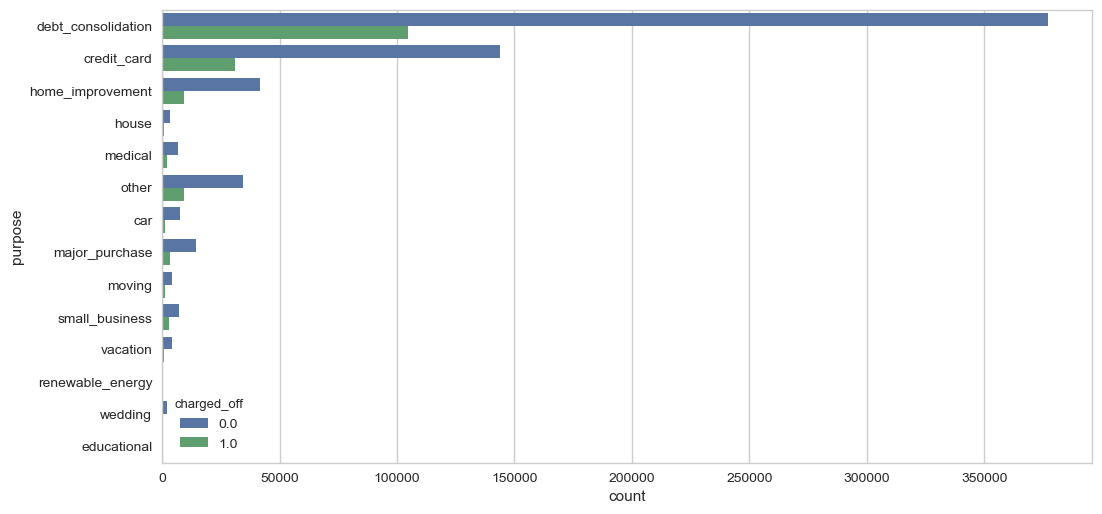

In [46]:
plt.figure(figsize=(12,6), dpi=100)
sns.countplot(y='purpose', hue='charged_off', data=df, orient='h')

Looks like most of the charge-offs come from loans for debt consolidation or to pay off credit cards.

Let's make a similar plot, but with 'sub_grade' instead of 'purpose'.

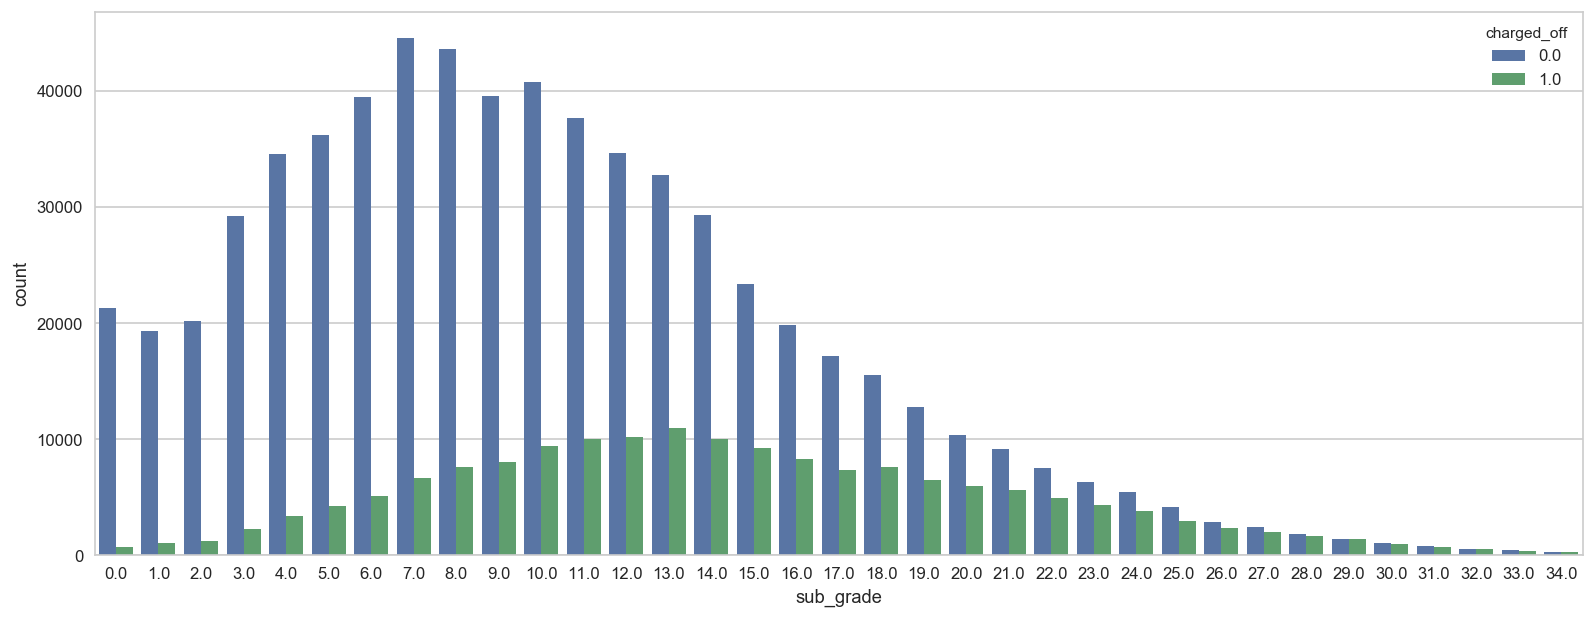

In [47]:
plt.figure(figsize=(16,6), dpi=120)
sns.countplot(x='sub_grade', hue='charged_off', data=df, order=sorted(df['sub_grade'].value_counts().index))

There's a clear trend of higher probability of charge-off as the subgrade worsens. (A higher value is a worse subgrade.)

Let's make a similar plot, but with 'term' instead of 'sub_grade'.

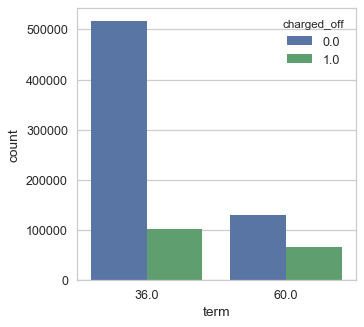

In [48]:
plt.figure(figsize=(4,4), dpi=90)
sns.countplot(x='term', hue='charged_off', data=df)

Loans with a term of 60 months are much more likely to be charged off.

Now let's compare the interest rate to the loan status using a kdeplot, which approximates the probability distribution of the data.

Text(0,0.5,'density')

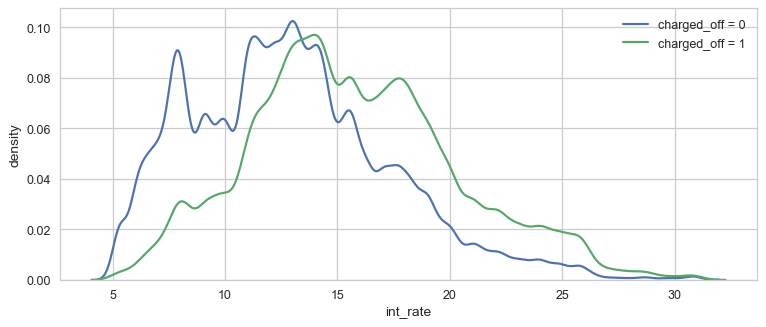

In [49]:
plt.figure(figsize=(10,4), dpi=90)
sns.kdeplot(df['int_rate'].loc[df['charged_off']==0], gridsize=500, label='charged_off = 0')
sns.kdeplot(df['int_rate'].loc[df['charged_off']==1], gridsize=500, label='charged_off = 1')
plt.xlabel('int_rate')
plt.ylabel('density')

Charged-off loans tend to have higher interest rates.

Now let's compare the borrower's most recent FICO score (a credit score) to the loan status.

Text(0,0.5,'density')

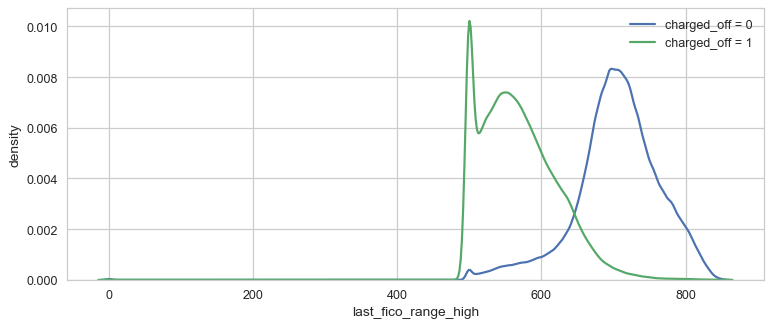

In [50]:
plt.figure(figsize=(10,4), dpi=90)
sns.kdeplot(df['last_fico_range_high'].loc[df['charged_off']==0], gridsize=500, label='charged_off = 0')
sns.kdeplot(df['last_fico_range_high'].loc[df['charged_off']==1], gridsize=500, label='charged_off = 1')
plt.xlabel('last_fico_range_high')
plt.ylabel('density')

Looks like charged-off loans tend to have much lower FICO scores.

# Correlations with 'charged_off'
<a id="6"></a>

By studying correlation coefficients, we can get an idea of which features correlate most strongly with 'charged_off'.

## Create dummy variables
<a id="6.1"></a>

To study correlations with 'charged_off', we need to convert categorial features to dummy variables.

In [51]:
cat_feats = []
for col in df.columns:
    if df[col].dtype == np.object:
        cat_feats.append(col)

cat_feats

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'disbursement_method']

In [52]:
df.shape

(814986, 88)

In [53]:
df = pd.get_dummies(df, columns=cat_feats, drop_first=True)

In [54]:
df.shape

(814986, 105)

We now have 105 features, all numerical. What does the dataframe look like after converting categorical features to dummy variables?

In [55]:
df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,annual_inc,charged_off,zip_code,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay
0,15000.0,15000.0,15000.0,60.0,12.39,336.64,10.0,10.0,78000.0,0.0,235.0,12.03,0.0,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,684.0,680.0,0.0,NaN,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,10400.0,10400.0,10400.0,36.0,6.99,321.08,2.0,8.0,58000.0,1.0,937.0,14.92,0.0,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,564.0,560.0,0.0,59.0,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,21425.0,21425.0,21425.0,60.0,15.59,516.36,15.0,6.0,63800.0,0.0,658.0,18.49,0.0,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2,35.0,704.0,700.0,0.0,74.0,0.0,0.0,42315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21500.0,NaN,NaN,NaN,4.0,4232.0,324.0,97.8,0.0,0.0,135.0,136.0,7.0,7.0,0.0,7.0,60.0,7.0,60.0,1.0,3.0,4.0,3.0,12.0,16.0,5.0,18.0,4.0,10.0,0.0,0.0,0.0,2.0,91.4,100.0,0.0,0.0,57073.0,42315.0,15000.0,35573.0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Compute correlations with 'charged_off'
<a id="6.2"></a>

Create the correlation matrix of all our data, then extract the 'charged_off' column. (Is there an easier way to compute correlations with only one variable?) Remove the entry for 'charged_off' (it's 1), and sort the features by their correlation coefficient with 'charged_off'.

In [56]:
corr_charged_off = df.corr()['charged_off']

In [57]:
corr_charged_off.drop(labels='charged_off', inplace=True)
corr_charged_off = corr_charged_off.sort_values()

Plot the correlation coefficients.

(-0.6866086165148878, 0.6866086165148878)

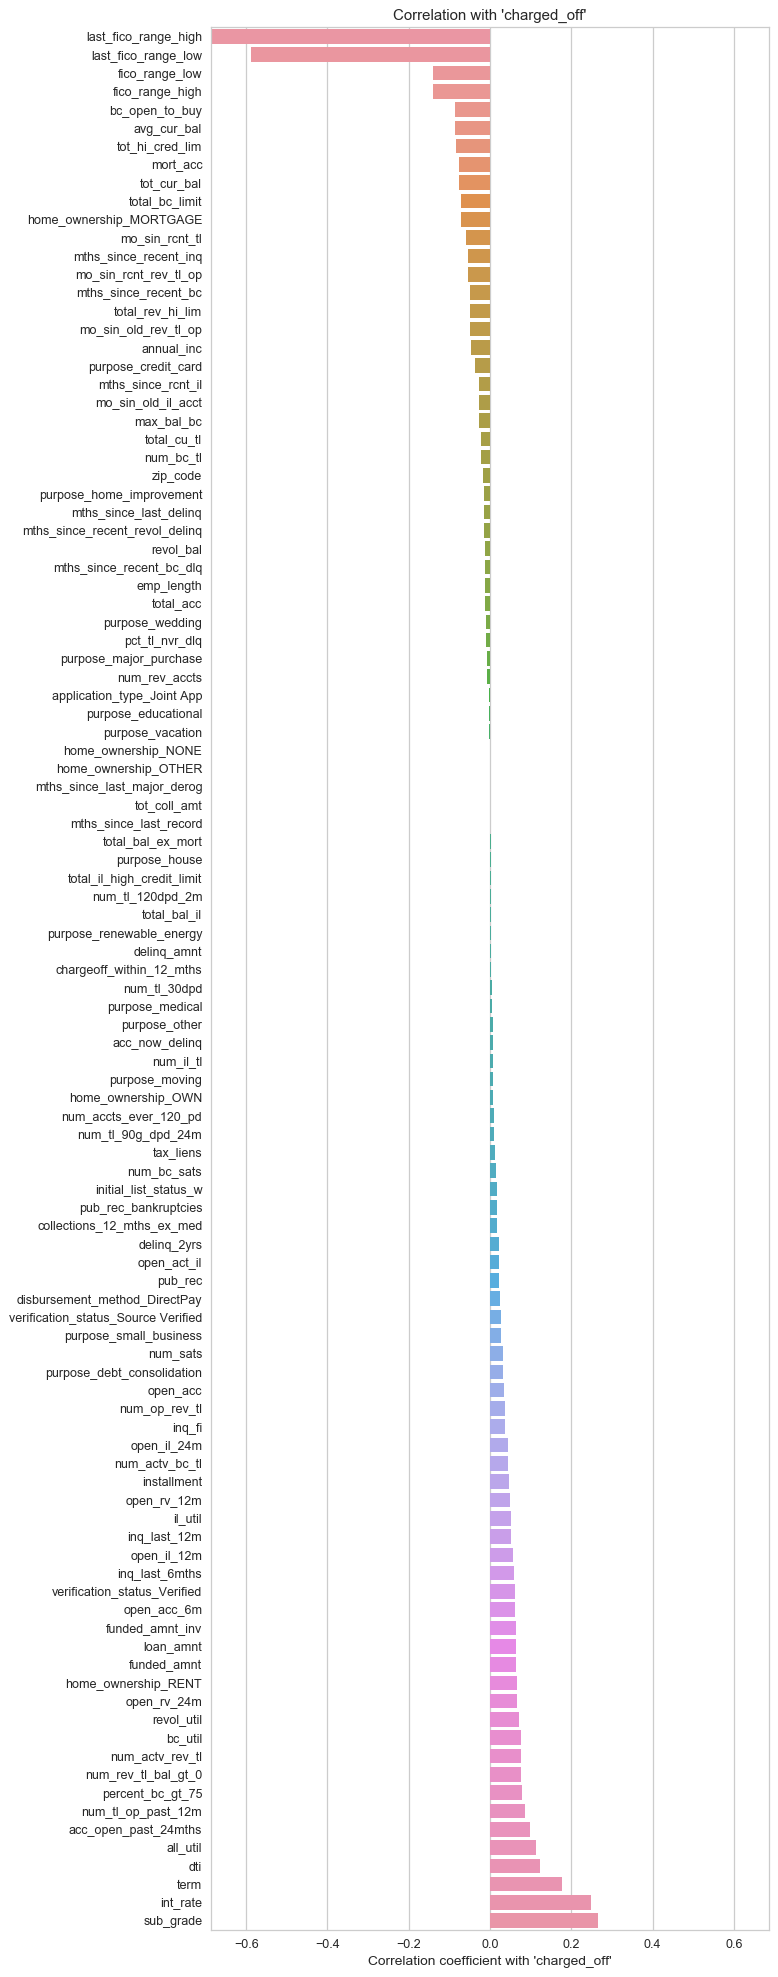

In [58]:
plt.figure(figsize=(8,28), dpi=90)
sns.barplot(y=corr_charged_off.index, x=corr_charged_off.values, orient='h')
plt.title("Correlation with 'charged_off'")
plt.xlabel("Correlation coefficient with 'charged_off'")
xmax = np.abs(corr_charged_off).max()
plt.xlim([-xmax, xmax])

**Things to note:** The borrower's most recent FICO scores are the features most negatively correlated with 'charged_off.' The debt-to-income ratio ('dti'), the number of payments on the loan ('term'), the interest rate ('int_rate'), and the subgrade ('sub_grade') are the features most positively correlated with 'charged_off'.

# More Pre-processing
<a id="7"></a>

Let's remind ourselves how much data we have.

In [59]:
df.shape

(814986, 105)

We have 814,986 samples and 105 features.

## Train/test split
<a id="7.1"></a>

In [60]:
X = df.drop(labels=['charged_off'], axis=1) # Features
y = df['charged_off'] # Target variable

In [61]:
from sklearn.model_selection import train_test_split

Let's do a 90/10 train/test split.

In [62]:
random_state = 12 # I chose this randomly, just to make the results fixed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

## Imputation with mean substitution
<a id="7.2"></a>

How complete is our training data?

In [63]:
pd.DataFrame((X_train.notnull().sum() / X_train.shape[0]).sort_values(), columns=['Fraction not null'])

,Fraction not null
mths_since_last_record,0.164777
il_util,0.190074
mths_since_rcnt_il,0.212698
all_util,0.217576
open_acc_6m,0.217591
total_cu_tl,0.217591
inq_last_12m,0.217591
max_bal_bc,0.217592
open_rv_12m,0.217592
total_bal_il,0.217592


The learning algorithms cannot have missing data. Perform mean substitution, using only the means of the training set to prevent test set leakage.

**Note:** I don't know that this is the best way to handle missing data. Should some columns simply be dropped? Should we impute some other way? Should incomplete rows be dropped?

In [64]:
from sklearn.preprocessing import Imputer

In [65]:
imputer = Imputer().fit(X_train)

In [66]:
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

## Standardize the data
<a id="7.3"></a>

Shift and scale each column individually so that it has zero mean and unit variance. This will help the learning algorithms.

Train the scaler using only the training data to prevent test set leakage.

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler().fit(X_train)

In [69]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Predictive Modeling: SGDClassifier
<a id="8"></a>

I decided to use a SGD Classifier by looking at the machine learning flowchart here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html.

The SGDClassifier estimator implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the 'loss' hyperparameter.

In [70]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Train with grid search
<a id="8.1"></a>

We're going to search through many hyperparameters of SGDClassifier using an exhaustive grid search with 3-fold cross-validation, implemented in GridSearchCV.

Here are the hyperparameters that we'll try:

In [71]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'class_weight': [None, 'balanced'],
               'warm_start': [True]},
              {'loss': ['log'],
               'penalty': ['l2', 'l1'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'warm_start': [True]}]

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [72]:
grid = GridSearchCV(estimator=SGDClassifier(), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), 
n_jobs=1, pre_dispatch=1, verbose=0, return_train_score=True)

Run the grid search (this could take some time).

In [73]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\metrics\cla

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'loss': ['hinge'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'max_iter': [1000], 'tol': [0.001], 'random_state': [12], 'class_weight': [None, 'balanced'], 'warm_start': [True]}, {'loss': ['log'], 'penalty': ['l2', 'l1'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'max_iter': [1000], 'tol': [0.001], 'random_state': [12], 'warm_start': [True]}],
       pre_dispatch=1, refit=True, return_train_score=True,
       scoring=make_scorer(matthews_corrcoef), verbose=1)

Hyperparameters that gave the best results on the hold out data:

In [74]:
grid.best_params_

{'alpha': 0.1,
 'class_weight': 'balanced',
 'loss': 'hinge',
 'max_iter': 1000,
 'random_state': 12,
 'tol': 0.001,
 'warm_start': True}

## Test set evaluation
<a id="8.2"></a>

In [75]:
y_pred = grid.predict(X_test)

In [76]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score

In [77]:
# Display classification evaluation metrics
def classification_eval(y_test, y_pred):
    dec = np.int64(np.ceil(np.log10(len(y_test)))) # Number of decimal places based on no. of samples
    print('Confusion matrix -----------------------'+3*(dec-1)*'-')
    print(confusion_matrix(y_test, y_pred), '\n')
    print('Classification report ------------------'+3*(dec-1)*'-')
    print(classification_report(y_test, y_pred, digits=dec))
    print('Scalar metrics -------------------------'+3*(dec-1)*'-')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

In [78]:
classification_eval(y_test, y_pred)

Confusion matrix -----------------------------------
[[58383  6224]
 [ 1782 15110]] 

Classification report ------------------------------
             precision    recall  f1-score   support

        0.0    0.97038   0.90366   0.93583     64607
        1.0    0.70826   0.89451   0.79056     16892

avg / total    0.91605   0.90177   0.90572     81499

Scalar metrics -------------------------------------
          MCC = 0.73598
Cohen's kappa = 0.72752
     Accuracy = 0.90177
